## `Import Library what we need`

In [553]:
# BASED
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
import pickle

# KERAS
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from keras.models import load_model
from keras.backend import clear_session


# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# SASTRAWI
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import  StopWordRemoverFactory

# WORD2VEC
import gensim

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 100
EPOCHS = 50
BATCH_SIZE = 1024

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\whisn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\whisn\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\whisn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [433]:
# Stopwords
nltk_stopwords = stopwords.words('indonesian')
sastrawi_factory = StopWordRemoverFactory()

# Stemming
stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()

# Tokenizer
tokenizer = Tokenizer()

## `Function`

In [602]:
# Tokenize
def tokenize(text):
    return text.split()


# Stopwords 
def stopwords_text(tokens): 
    cleaned_tokens = []
    for token in tokens : 
        if token not in sastrawi_stopwords: 
            cleaned_tokens.append(token)
    return cleaned_tokens


# Stemming
def stem_words(tokens):
  hasil = [stemmer.stem(token) for token in tokens]
  return hasil


# Untokenize
def untokenize(texts):
    text = ""
    for i in texts:
        text += f"{i}"
        text += " "
    return text.rstrip()


# Encoding
def manual_label_encoder(labels):
    unique_labels = list(set(labels))  # Mendapatkan label unik
    label_index = {label: index for index, label in enumerate(unique_labels)}  # Membuat kamus untuk mapping label ke bilangan bulat
    encoded_labels = [label_index[label] for label in labels]  # Encoding label menjadi bilangan bulat
    return encoded_labels, label_index

def reshape_labels(encoded_labels):
    reshaped_labels = [[label] for label in encoded_labels]  # Reshape array hasil encoding ke bentuk (jumlah_data, 1)
    return reshaped_labels


# Normalize Label Text
def normalize_label(df):
    df['Label'] = df['Label'].str.strip().str.lower()
    df['Label'] = df['Label'].replace('netral', 'negatif')
    return df


# Create 1D Array from 2D Array
def merge_2d_array_to_1d(df_column):
    merged = [word for sublist in df_column for word in sublist]
    return merged


# Create Word Freq
def word_freq_func(data, label):
    # Menghitung frekuensi kemunculan setiap kata dan kolom 'Label'
    word_freq = {}
    for word, label in zip(data, label):
        if word in word_freq:
            if label == 'positif':
                word_freq[word][0] += 1
            else:
                word_freq[word][1] += 1
        else:
            if label == 'positif':
                word_freq[word] = [1, 0]
            else:
                word_freq[word] = [0, 1]
    return word_freq


# Tokenize Column
def tokenize_column(dataframe, column_name):
    tokenized_documents = [text.split() for text in dataframe[column_name]]
    return tokenized_documents


# Calculate Similarity
def calculate_similarity(keyword, w2v_model):
    similarities = []
    # Melakukan iterasi pada setiap kata dalam model
    for word in w2v_model.wv.index_to_key:
        # Menangkap pengecualian jika kata tidak ada dalam model
        try:
            # Menghitung kemiripan antara kata dalam kosakata dengan kata kunci
            similarity = w2v_model.wv.similarity(keyword, word)      
            # Menambahkan ke list similarities
            similarities.append((word, similarity))
        except KeyError:
            # Tangani jika kata tidak ditemukan dalam model
            print(f"Word '{word}' not in vocabulary.")
    # Buat DataFrame dari list similarities
    df = pd.DataFrame(similarities, columns=['Keyword', 'Similarity'])
    # Sorting DataFrame secara descending berdasarkan similarity
    df = df.sort_values(by='Similarity', ascending=False)
    return df


# Get n Items from Dictionary
def get_top_n_items(dictionary, n, seq):
    # Mengambil n item teratas dari dictionary berdasarkan frekuensi kemunculan
    top_n = dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=seq)[:n])
    return top_n

# Create Embedding Matrix
def create_embedding_matrix(vocab_size, tokenizer, w2v_model):
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))

    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]

    return embedding_matrix


def manual_evaluate(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred_binary = (y_pred > 0.5).astype('int32')  # Konversi probabilitas menjadi nilai biner

    accuracy = tensorflow.reduce_mean(tensorflow.cast(y_pred_binary == y_test, tensorflow.float32))  # Menghitung akurasi dari perbandingan boolean
    return accuracy


def display_confusion_heatmap(y_test, y_preds, model_names):
    num_models = len(y_preds)
    num_rows = num_models // 2 + num_models % 2  # Hitung jumlah baris berdasarkan jumlah model
    plt.figure(figsize=(12, 8))  # Atur ukuran gambar secara keseluruhan
    for i, y_pred in enumerate(y_preds):
        # Hitung TP, TN, FP, FN
        TP, TN, FP, FN = manual_heatmap(y_test, y_pred)

        # Bentuk matrix confusion
        confusion_matrix = [[TN, FP], [FN, TP]]

        # Label untuk heatmap
        labels = [['TN', 'FP'], ['FN', 'TP']]

        # Plot heatmap dalam subplot
        plt.subplot(num_rows, 2, i + 1)
        sns.heatmap(confusion_matrix, annot=False, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

        # Menambahkan label ke heatmap
        for j in range(2):
            for k in range(2):
                plt.text(k + 0.5, j + 0.5, str(labels[j][k]) + " = " + str(confusion_matrix[j][k]), ha='center', va='center', color='black')

        plt.title(f'Confusion Matrix - {model_names[i]}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
    
    plt.tight_layout()  # Menata layout subplot agar rapi
    plt.show()

def manual_heatmap(y_test, y_pred):
    # Menginisialisasi variabel untuk TP, TN, FP, FN
    TP, TN, FP, FN = 0, 0, 0, 0
    
    # Menghitung TP, TN, FP, FN
    for actual, pred in zip(y_test, y_pred):
        if actual == "positif" and pred == "positif":
            TP += 1
        elif actual == "negatif" and pred == "negatif":
            TN += 1
        elif actual == "negatif" and pred == "positif":
            FP += 1
        elif actual == "positif" and pred == "negatif":
            FN += 1
    
    return TP, TN, FP, FN


def check_test_accuracy(y_pred, y_test):
    # Menghitung jumlah prediksi yang benar (True)
    correct_predictions = sum(1 for pred, actual in zip(y_pred, y_test) if pred == actual)

    # Menghitung akurasi
    total_predictions = len(y_pred)
    accuracy = correct_predictions / total_predictions
    return accuracy


def create_lstm_model(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [435]:
class CustomLSTM(tensorflow.keras.layers.Layer):
    def __init__(self, units, dropout, recurrent_dropout):
        super(CustomLSTM, self).__init__()
        self.units = units
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout

    def build(self, input_shape):
        self.input_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(self.input_dim + self.units, 4 * self.units),
            initializer='glorot_uniform',
            name='kernel'
        )
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, 4 * self.units),
            initializer='orthogonal',
            name='recurrent_kernel'
        )
        self.bias = self.add_weight(
            shape=(4 * self.units,),
            initializer='zeros',
            name='bias'
        )
        self.built = True

    def call(self, inputs, states=None, training=None):
        h_tm1 = states[0] if states else tensorflow.zeros((tensorflow.shape(inputs)[0], self.units))
        c_tm1 = states[1] if states else tensorflow.zeros((tensorflow.shape(inputs)[0], self.units))

        if training is None:
            training = tensorflow.keras.backend.learning_phase()

        if 0 < self.dropout < 1 and self.dropout is not None:
            inputs = tensorflow.keras.layers.Dropout(self.dropout)(inputs, training=training)

        concat_inputs = tensorflow.concat([inputs, h_tm1], axis=-1)
        gate_inputs = tensorflow.matmul(concat_inputs, self.kernel) + self.bias

        i, f, g, o = tensorflow.split(gate_inputs, 4, axis=-1)
        i = tensorflow.sigmoid(i)
        f = tensorflow.sigmoid(f)
        g = tensorflow.tanh(g)
        o = tensorflow.sigmoid(o)

        c = f * c_tm1 + i * g

        if 0 < self.recurrent_dropout < 1 and self.recurrent_dropout is not None:
            c = tensorflow.keras.layers.Dropout(self.recurrent_dropout)(c, training=training)

        h = o * tensorflow.tanh(c)

        return h, [h, c]

    def get_config(self):
        config = super().get_config()
        config.update({
            'units': self.units,
            'dropout': self.dropout,
            'recurrent_dropout': self.recurrent_dropout
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


### `Read Data`

In [436]:
df = pd.read_csv('./dataset/data-label.csv')
copy_df = df.copy()
df.head()

,full_text,text_clean,Label
0,@PartaiSocmed Sumber = tiktok TKN Prabowo Gibr...,sumber tiktok tkn prabowo gibran,netral
1,Solidaritas positif Mantan Kepala Desa: Prabow...,solidaritas positif mantan kepala desa prabowo...,positif
2,Keputusan mantan Kepala Desa: Prabowo-Gibran a...,keputusan mantan kepala desa prabowogibran ada...,positif
3,Ahmad dhani kampanye PRABOWO GIBRAN 🫰🫰🫰🫰🫰🫰🫰 ht...,ahmad dhani kampanye prabowo gibran,positif
4,Pilihan optimis Mantan Kepala Desa: Prabowo-Gi...,pilihan optimis mantan kepala desa prabowogibr...,positif


In [437]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876 entries, 0 to 891
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   full_text   876 non-null    object
 1   text_clean  876 non-null    object
 2   Label       876 non-null    object
dtypes: object(3)
memory usage: 27.4+ KB


### `Tokenize`

In [438]:
df['token'] = df['text_clean'].apply(tokenize)
df.head(2)

,full_text,text_clean,Label,token
0,@PartaiSocmed Sumber = tiktok TKN Prabowo Gibr...,sumber tiktok tkn prabowo gibran,netral,"[sumber, tiktok, tkn, prabowo, gibran]"
1,Solidaritas positif Mantan Kepala Desa: Prabow...,solidaritas positif mantan kepala desa prabowo...,positif,"[solidaritas, positif, mantan, kepala, desa, p..."


### `Stopwords`

In [503]:
print(nltk_stopwords[:5])
print(len(nltk_stopwords))

['ada', 'adalah', 'adanya', 'adapun', 'agak']
758


In [504]:
sastrawi_stopwords = sastrawi_factory.get_stop_words()
print(sastrawi_stopwords[:5])
print(len(sastrawi_stopwords))

['yang', 'untuk', 'pada', 'ke', 'para']
126


In [441]:
df['stop'] = df['token'].apply(stopwords_text)
df.head(2)

,full_text,text_clean,Label,token,stop
0,@PartaiSocmed Sumber = tiktok TKN Prabowo Gibr...,sumber tiktok tkn prabowo gibran,netral,"[sumber, tiktok, tkn, prabowo, gibran]","[sumber, tiktok, tkn, prabowo, gibran]"
1,Solidaritas positif Mantan Kepala Desa: Prabow...,solidaritas positif mantan kepala desa prabowo...,positif,"[solidaritas, positif, mantan, kepala, desa, p...","[solidaritas, positif, mantan, kepala, desa, p..."


### `Stemming`

In [442]:
df['stemmed'] = df['stop'].apply(stem_words)
df.head(2)

,full_text,text_clean,Label,token,stop,stemmed
0,@PartaiSocmed Sumber = tiktok TKN Prabowo Gibr...,sumber tiktok tkn prabowo gibran,netral,"[sumber, tiktok, tkn, prabowo, gibran]","[sumber, tiktok, tkn, prabowo, gibran]","[sumber, tiktok, tkn, prabowo, gibran]"
1,Solidaritas positif Mantan Kepala Desa: Prabow...,solidaritas positif mantan kepala desa prabowo...,positif,"[solidaritas, positif, mantan, kepala, desa, p...","[solidaritas, positif, mantan, kepala, desa, p...","[solidaritas, positif, mantan, kepala, desa, p..."


In [443]:
df = df[['full_text', 'text_clean', 'token', 'stop', 'stemmed', 'Label']]
df.head(2)

,full_text,text_clean,token,stop,stemmed,Label
0,@PartaiSocmed Sumber = tiktok TKN Prabowo Gibr...,sumber tiktok tkn prabowo gibran,"[sumber, tiktok, tkn, prabowo, gibran]","[sumber, tiktok, tkn, prabowo, gibran]","[sumber, tiktok, tkn, prabowo, gibran]",netral
1,Solidaritas positif Mantan Kepala Desa: Prabow...,solidaritas positif mantan kepala desa prabowo...,"[solidaritas, positif, mantan, kepala, desa, p...","[solidaritas, positif, mantan, kepala, desa, p...","[solidaritas, positif, mantan, kepala, desa, p...",positif


### `Exploratory Data Analysis`

In [444]:
df['Label'].value_counts()

negatif     499
positif     373
negatif       3
netral        1
Name: Label, dtype: int64

In [445]:
df = normalize_label(df)
print(df['Label'].value_counts())

negatif    503
positif    373
Name: Label, dtype: int64


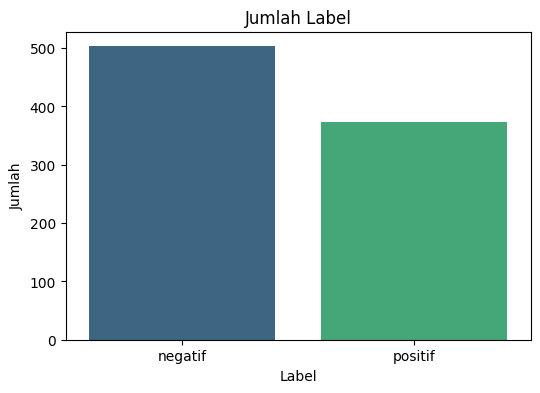

In [446]:
counts = df['Label'].value_counts()
plt.figure(figsize=(6, 4))  # Mengatur ukuran plot

sns.barplot(x=counts.index, y=counts.values, palette='viridis')

plt.title('Jumlah Label')
plt.xlabel('Label')
plt.ylabel('Jumlah')

plt.show()

In [447]:
# Menggabungkan semua list menjadi satu list tunggal
merged_stemming = merge_2d_array_to_1d(df['stemmed'])
merged_stemming[:5]

['sumber', 'tiktok', 'tkn', 'prabowo', 'gibran']

In [448]:
word_freq = word_freq_func(merged_stemming, df['Label'])
print(word_freq)

{'sumber': [0, 1], 'tiktok': [1, 0], 'tkn': [1, 0], 'prabowo': [20, 20], 'gibran': [17, 23], 'solidaritas': [1, 1], 'positif': [8, 3], 'mantan': [12, 15], 'kepala': [3, 4], 'desa': [7, 5], 'prabowogibran': [22, 18], 'langkah': [1, 0], 'maju': [1, 0], 'putus': [1, 1], 'jalan': [1, 0], 'ubah': [8, 7], 'ingin': [0, 2], 'ahmad': [0, 1], 'dhani': [1, 0], 'kampanye': [1, 0], 'pilih': [1, 5], 'optimis': [0, 1], 'pimpin': [7, 12], 'iring': [1, 1], 'suara': [2, 5], 'bulat': [0, 2], 'ratus': [4, 3], 'kades': [6, 9], 'bangun': [2, 2], 'nyata': [4, 2], 'cipta': [3, 1], 'harmoni': [0, 1], 'dukung': [7, 14], 'pilpres': [2, 3], 'satu': [1, 4], 'lebih': [5, 2], 'baik': [2, 3], 'sama': [1, 3], 'komitmen': [1, 1], 'percaya': [1, 0], 'narasi': [1, 0], 'penuh': [1, 1], 'solusi': [1, 0], 'semangat': [2, 2], 'segar': [1, 0], 'kotakabupaten': [1, 2], 'cirebon': [7, 5], 'buat': [1, 1], 'atmosfer': [1, 0], 'katalisator': [1, 0], 'mentang': [1, 0], 'jadi': [1, 2], 'caprescawapres': [0, 1], 'terus': [1, 1], 'ser

In [449]:
# Membuat DataFrame dari hasil perhitungan frekuensi kata dan kolom 'Label'
df_word_freq = pd.DataFrame(word_freq.items(), columns=['Kata', 'Jumlah'])
df_word_freq[['Jumlah_Positif', 'Jumlah_Negatif']] = pd.DataFrame(df_word_freq['Jumlah'].tolist(), index=df_word_freq.index)
df_word_freq.drop('Jumlah', axis=1, inplace=True)
df_word_freq.head()

,Kata,Jumlah_Positif,Jumlah_Negatif
0,sumber,0,1
1,tiktok,1,0
2,tkn,1,0
3,prabowo,20,20
4,gibran,17,23


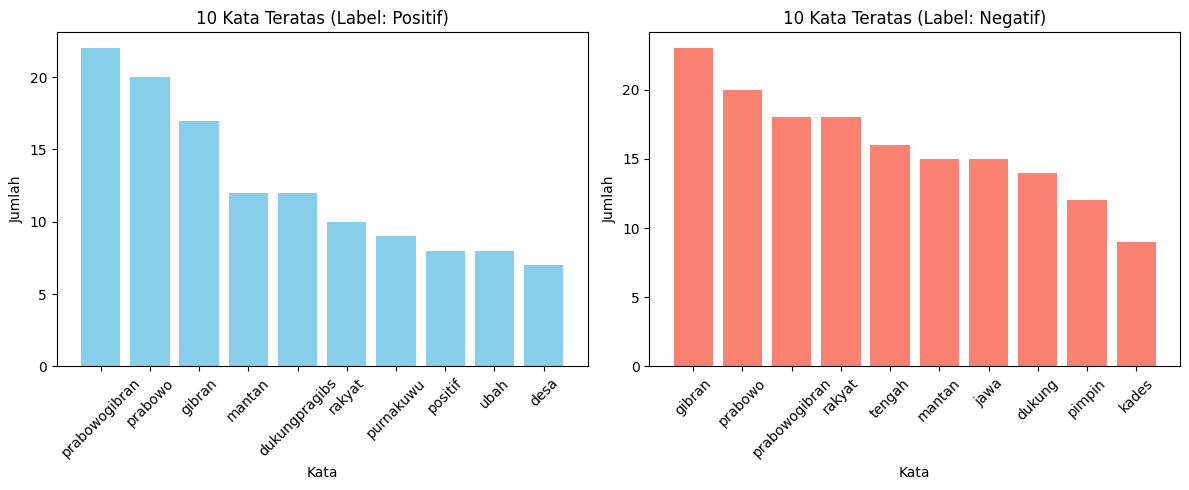

In [450]:
# Mengambil 10 kata teratas untuk masing-masing label
top_positif = df_word_freq.nlargest(10, 'Jumlah_Positif')
top_negatif = df_word_freq.nlargest(10, 'Jumlah_Negatif')

# Plot bar chart untuk 10 kata teratas masing-masing label
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(top_positif['Kata'], top_positif['Jumlah_Positif'], color='skyblue')
plt.title('10 Kata Teratas (Label: Positif)')
plt.xticks(rotation=45)
plt.xlabel('Kata')
plt.ylabel('Jumlah')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.bar(top_negatif['Kata'], top_negatif['Jumlah_Negatif'], color='salmon')
plt.title('10 Kata Teratas (Label: Negatif)')
plt.xticks(rotation=45)
plt.xlabel('Kata')
plt.ylabel('Jumlah')
plt.tight_layout()

plt.show()

### `WORD2VEC MODEL`

In [451]:
df.head(2)

,full_text,text_clean,token,stop,stemmed,Label
0,@PartaiSocmed Sumber = tiktok TKN Prabowo Gibr...,sumber tiktok tkn prabowo gibran,"[sumber, tiktok, tkn, prabowo, gibran]","[sumber, tiktok, tkn, prabowo, gibran]","[sumber, tiktok, tkn, prabowo, gibran]",negatif
1,Solidaritas positif Mantan Kepala Desa: Prabow...,solidaritas positif mantan kepala desa prabowo...,"[solidaritas, positif, mantan, kepala, desa, p...","[solidaritas, positif, mantan, kepala, desa, p...","[solidaritas, positif, mantan, kepala, desa, p...",positif


In [452]:
df['untokenize_clean'] = df['stemmed'].apply(untokenize)
df = df[['full_text', 'text_clean', 'token', 'stop', 'stemmed','untokenize_clean', 'Label']]
df.head(2)

,full_text,text_clean,token,stop,stemmed,untokenize_clean,Label
0,@PartaiSocmed Sumber = tiktok TKN Prabowo Gibr...,sumber tiktok tkn prabowo gibran,"[sumber, tiktok, tkn, prabowo, gibran]","[sumber, tiktok, tkn, prabowo, gibran]","[sumber, tiktok, tkn, prabowo, gibran]",sumber tiktok tkn prabowo gibran,negatif
1,Solidaritas positif Mantan Kepala Desa: Prabow...,solidaritas positif mantan kepala desa prabowo...,"[solidaritas, positif, mantan, kepala, desa, p...","[solidaritas, positif, mantan, kepala, desa, p...","[solidaritas, positif, mantan, kepala, desa, p...",solidaritas positif mantan kepala desa prabowo...,positif


In [453]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
print("Train size:", len(df_train))
print("Test size:", len(df_test))

Train size: 613
Test size: 263


In [636]:
df_train.head(2)

,full_text,text_clean,token,stop,stemmed,untokenize_clean,Label
836,Prabowo-Gibran pilihan yang diakui oleh ratus...,prabowogibran pilihan yang diakui oleh ratusan...,"[prabowogibran, pilihan, yang, diakui, oleh, r...","[prabowogibran, pilihan, diakui, ratusan, mant...","[prabowogibran, pilih, aku, ratus, mantan, kad...",prabowogibran pilih aku ratus mantan kades lur...,positif
181,Dari Jawa Timur untuk Ganjar-Mahfud: Ngomong d...,dari jawa timur untuk ganjarmahfud ngomong doa...,"[dari, jawa, timur, untuk, ganjarmahfud, ngomo...","[jawa, timur, ganjarmahfud, ngomong, doang, ga...","[jawa, timur, ganjarmahfud, ngomong, doang, ga...",jawa timur ganjarmahfud ngomong doang gampang ...,negatif


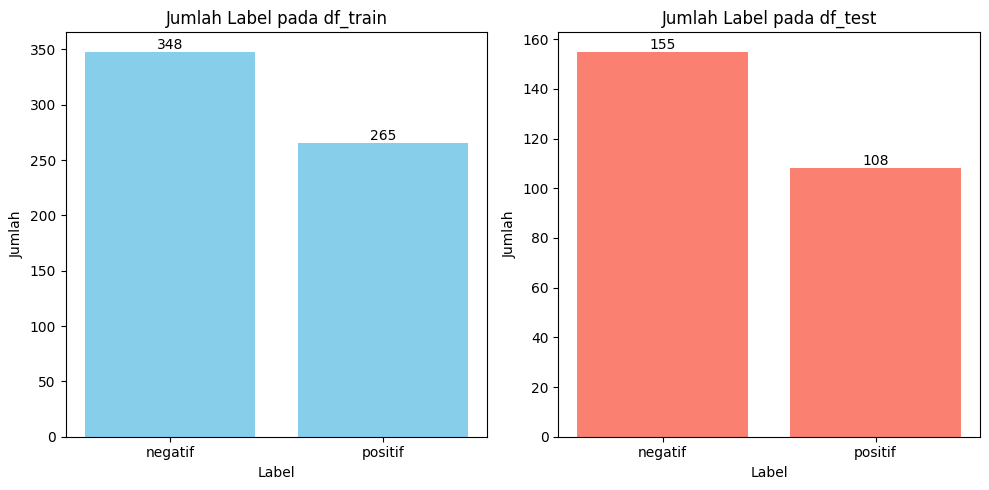

In [653]:
# Menghitung jumlah label untuk setiap nilai unik dalam kolom 'Label' pada df_train dan df_test
train_label_counts = df_train.groupby('Label').size()
test_label_counts = df_test.groupby('Label').size()

# Data train dan test
data = [train_label_counts, test_label_counts]
titles = ['Jumlah Label pada df_train', 'Jumlah Label pada df_test']
colors = ['skyblue', 'salmon']

# Menyiapkan subplots dalam satu canvas
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for i, (label, counts) in enumerate(zip(['df_train', 'df_test'], data)):
    bars = ax[i].bar(counts.index, counts, color=colors[i])
    ax[i].set_xlabel('Label')
    ax[i].set_ylabel('Jumlah')
    ax[i].set_title(titles[i])
    
    # Menambahkan label pada setiap bar
    for bar in bars:
        yval = bar.get_height()
        ax[i].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [456]:
df_train.head(2)

,full_text,text_clean,token,stop,stemmed,untokenize_clean,Label
836,Prabowo-Gibran pilihan yang diakui oleh ratus...,prabowogibran pilihan yang diakui oleh ratusan...,"[prabowogibran, pilihan, yang, diakui, oleh, r...","[prabowogibran, pilihan, diakui, ratusan, mant...","[prabowogibran, pilih, aku, ratus, mantan, kad...",prabowogibran pilih aku ratus mantan kades lur...,positif
181,Dari Jawa Timur untuk Ganjar-Mahfud: Ngomong d...,dari jawa timur untuk ganjarmahfud ngomong doa...,"[dari, jawa, timur, untuk, ganjarmahfud, ngomo...","[jawa, timur, ganjarmahfud, ngomong, doang, ga...","[jawa, timur, ganjarmahfud, ngomong, doang, ga...",jawa timur ganjarmahfud ngomong doang gampang ...,negatif


In [457]:
documents = tokenize_column(df_train, 'untokenize_clean')
print(len(documents))
documents[:2]

613


[['prabowogibran',
  'pilih',
  'aku',
  'ratus',
  'mantan',
  'kades',
  'lurah',
  'cirebon',
  'purnakuwu',
  'dukungpragibs'],
 ['jawa',
  'timur',
  'ganjarmahfud',
  'ngomong',
  'doang',
  'gampang',
  'bang',
  'gibran',
  'mending',
  'dukung',
  'kerja',
  'nyata',
  'bukan',
  'debat',
  'kotak',
  'amal',
  'doang']]

In [458]:
# Inisialisasi model Word2Vec dengan parameter:
# - vector_size: Menentukan jumlah dimensi vektor untuk merepresentasikan kata-kata dalam model Word2Vec.
# - window: Parameter yang menentukan jendela konteks kata dalam teks yang akan dilihat oleh model saat melatih vektor kata.
# - min_count: Menentukan jumlah minimum kemunculan kata yang diperlukan agar kata tersebut diikutsertakan dalam pembangunan vektor kata.
# - workers: Menentukan jumlah thread atau pekerja yang akan digunakan saat melatih model.

w2v_model = gensim.models.Word2Vec(
                                    vector_size=W2V_SIZE, 
                                    window=W2V_WINDOW, 
                                    min_count=W2V_MIN_COUNT, 
                                    workers=8
                                   )

w2v_model.build_vocab(documents)

In [459]:
words = w2v_model.wv.index_to_key  # Mendapatkan daftar kata-kata dari model Word2Vec
vocab_size = len(words)  # Menghitung ukuran vocabulary
print("Vocab size:", vocab_size)

Vocab size: 162


In [511]:
print(words[:3])

['prabowo', 'dukung', 'gibran']


In [461]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(85186, 269312)

In [462]:
similar_words = w2v_model.wv.most_similar('prabowo')
similar_words

[('ham', 0.9947798252105713),
 ('langgar', 0.9917493462562561),
 ('yg', 0.9911535978317261),
 ('mau', 0.9906655550003052),
 ('culik', 0.990477442741394),
 ('gemoy', 0.9888845682144165),
 ('orang', 0.986030101776123),
 ('malah', 0.9842602014541626),
 ('tanya', 0.983856737613678),
 ('pernah', 0.9836750030517578)]

In [463]:
# Contoh penggunaan fungsi
keyword = 'prabowo'  # Ganti dengan kata kunci Anda
# Ganti 'w2v_model' dengan model Word2Vec yang Anda miliki
result_df = calculate_similarity(keyword, w2v_model)
print(result_df.head(2))
print(result_df.tail(2))

    Keyword  Similarity
0   prabowo     1.00000
23      ham     0.99478
     Keyword  Similarity
8  purnakuwu    0.109508
6     mantan    0.103224


### `Model Preparation`

In [464]:
df_train.head(2)

,full_text,text_clean,token,stop,stemmed,untokenize_clean,Label
836,Prabowo-Gibran pilihan yang diakui oleh ratus...,prabowogibran pilihan yang diakui oleh ratusan...,"[prabowogibran, pilihan, yang, diakui, oleh, r...","[prabowogibran, pilihan, diakui, ratusan, mant...","[prabowogibran, pilih, aku, ratus, mantan, kad...",prabowogibran pilih aku ratus mantan kades lur...,positif
181,Dari Jawa Timur untuk Ganjar-Mahfud: Ngomong d...,dari jawa timur untuk ganjarmahfud ngomong doa...,"[dari, jawa, timur, untuk, ganjarmahfud, ngomo...","[jawa, timur, ganjarmahfud, ngomong, doang, ga...","[jawa, timur, ganjarmahfud, ngomong, doang, ga...",jawa timur ganjarmahfud ngomong doang gampang ...,negatif


In [465]:
tokenizer.fit_on_texts(df_train['untokenize_clean'])
print(get_top_n_items(tokenizer.word_index, 5, False))

{'prabowo': 1, 'gibran': 2, 'dukung': 3, 'prabowogibran': 4, 'ganjar': 5}


In [466]:
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 1721


In [467]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.untokenize_clean), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.untokenize_clean), maxlen=SEQUENCE_LENGTH)

Wall time: 21 ms


In [468]:
x_train[:2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   4,
         20, 109,  43,   7,  11,  63,  12,   8,   9],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [469]:
x_test[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   13,   16,   41,    5,
          14,   84,    6,  134,  119,  194,  136,    2,   56,   59,   42,
          10],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    

### `Encoding`

In [470]:
# Data target dari dataframe
target_train = df_train['Label'].tolist()
target_test = df_test['Label'].tolist()
target_train[:3]


['positif', 'negatif', 'positif']

In [471]:
# Encoding label secara manual
y_train_encoded, label_index = manual_label_encoder(target_train)
y_test_encoded = [label_index[label] for label in target_test]  # Menggunakan mapping yang sama untuk data test
y_train_encoded[:3]

[0, 1, 0]

In [599]:
# Reshape array hasil encoding
y_train = reshape_labels(y_train_encoded)
y_test = reshape_labels(y_test_encoded)
print(y_train[:3])
print(y_test[:3])

[[0], [1], [0]]
[[1], [1], [0]]


In [473]:
np.unique(y_train)

array([0, 1])

### `Embedding Layer`

In [521]:
embedding_matrix = create_embedding_matrix(vocab_size, tokenizer, w2v_model)
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09629598,  0.18890738, -0.0112006 , ..., -0.13138133,
         0.13306515,  0.07319795],
       [ 0.0610792 ,  0.30105078, -0.06177893, ..., -0.18441232,
        -0.0339874 ,  0.00277997],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### `Build Model`

In [570]:
# Membersihkan session Keras sebelum membuat model baru
clear_session()

In [572]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [574]:
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          516300    
                                                                 
 dropout_1 (Dropout)         (None, 100, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 676,801
Trainable params: 160,501
Non-trainable params: 516,300
_________________________________________________________________


In [575]:
lstm_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [478]:
lstm_custom_model = Sequential()
lstm_custom_model.add(embedding_layer)
lstm_custom_model.add(Dropout(0.5))
lstm_custom_model.add(CustomLSTM(units=100, dropout=0.2, recurrent_dropout=0.2))
lstm_custom_model.add(Dense(1, activation='sigmoid'))

lstm_custom_model.summary()

ValueError: Exception encountered when calling layer "custom_lstm_5" (type CustomLSTM).

in user code:

    File "C:\Users\whisn\AppData\Local\Temp\ipykernel_40436\1237685356.py", line 37, in call  *
        concat_inputs = tensorflow.concat([inputs, h_tm1], axis=-1)

    ValueError: Shape must be rank 3 but is rank 2 for '{{node custom_lstm_5/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](custom_lstm_5/dropout/Identity, custom_lstm_5/zeros, custom_lstm_5/concat/axis)' with input shapes: [?,100,300], [?,100], [].


Call arguments received by layer "custom_lstm_5" (type CustomLSTM):
  • inputs=tf.Tensor(shape=(None, 100, 300), dtype=float32)
  • states=None
  • training=None

In [576]:
gru_model = Sequential()
gru_model.add(embedding_layer)
gru_model.add(Dropout(0.5))
gru_model.add(GRU(units=100, dropout=0.2, recurrent_dropout=0.2))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          516300    
                                                                 
 dropout_2 (Dropout)         (None, 100, 300)          0         
                                                                 
 gru (GRU)                   (None, 100)               120600    
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 637,001
Trainable params: 120,701
Non-trainable params: 516,300
_________________________________________________________________


In [577]:
gru_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [578]:
models = []
model_names = ['LSTM', 'GRU']
models.append(lstm_model)
models.append(gru_model)

### `Train`

In [579]:
x_train[:1]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   4,
         20, 109,  43,   7,  11,  63,  12,   8,   9]])

In [600]:
# Ubah x_train dan y_train menjadi tensor
x_train_tensor = tensorflow.convert_to_tensor(x_train)
y_train_tensor = tensorflow.convert_to_tensor(y_train)
x_test_tensor = tensorflow.convert_to_tensor(x_test)
y_test_tensor = tensorflow.convert_to_tensor(y_test)

In [582]:
x_train_tensor[:1]

<tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   4,
         20, 109,  43,   7,  11,  63,  12,   8,   9]])>

In [583]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [584]:
histories = []  # Untuk menyimpan riwayat pelatihan setiap model

for model in models:
    history = model.fit(x_train_tensor, y_train_tensor,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_split=0.1,
                        verbose=1,
                        callbacks=callbacks)
    histories.append(history)


Epoch 1/50


1/1 [==============================] - 9s 9s/step - loss: 0.6841 - accuracy: 0.5953 - val_loss: 0.6178 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 3s 3s/step - loss: 0.6215 - accuracy: 0.8348 - val_loss: 0.5578 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.5658 - accuracy: 0.8457 - val_loss: 0.5038 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 3s 3s/step - loss: 0.5154 - accuracy: 0.8530 - val_loss: 0.4547 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 4s 4s/step - loss: 0.4683 - accuracy: 0.8494 - val_loss: 0.4103 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 6/50
1/1 [==============================] - 4s 4s/step - loss: 0.4263 - accuracy: 0.8548 - val_loss: 0.3712 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 1/50
1/1 [==============================] - 8s 8s/step - loss: 0.7332 - accuracy: 0.3448 - val_loss: 0.65

In [585]:
# Menampilkan akurasi terakhir dari setiap model
for idx, history in enumerate(histories):
    last_accuracy = history.history['accuracy'][-1]  # Untuk mendapatkan akurasi terakhir
    print(f"model {model_names[idx]}: {last_accuracy}")

model LSTM: 0.8548094630241394
model GRU: 0.8384755253791809


In [586]:
lstm_model.save('lstm.h5')
gru_model.save('gru.h5')

### `Evaluate`

In [605]:
for i, model in enumerate(models): 
    # print(i)
    accuracy = manual_evaluate(model, x_test_tensor, y_test_tensor)
    print(f"Model {model_names[i]} - Accuracy: {accuracy}")

9/9 [==============================] - 1s 134ms/step
Model LSTM - Accuracy: 0.8441064357757568
9/9 [==============================] - 1s 99ms/step
Model GRU - Accuracy: 0.8212927579879761


In [604]:
y_test_tensor

<tf.Tensor: shape=(263, 1), dtype=int32, numpy=
array([[1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
    

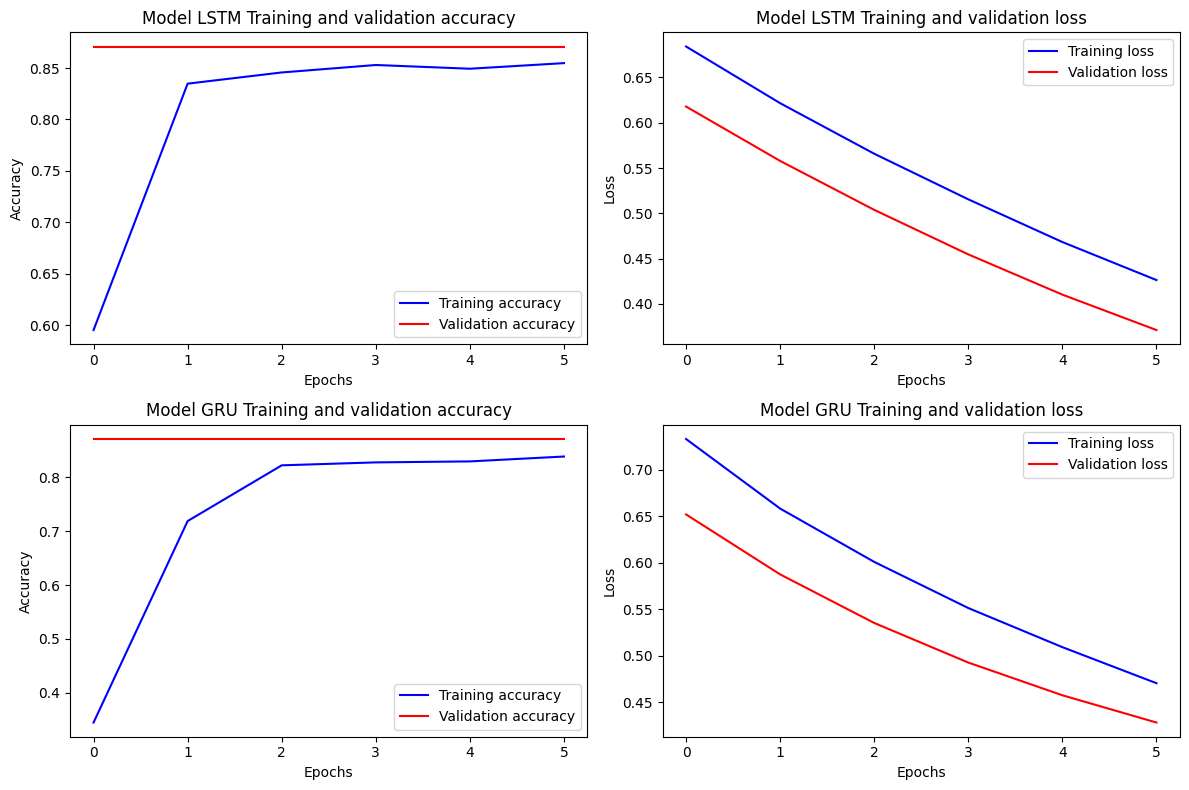

In [607]:
num_models = len(models)

plt.figure(figsize=(12, 4*num_models))

for i, history in enumerate(histories):
    plt.subplot(num_models, 2, 2*i+1)
    plt.plot(history.history['accuracy'], 'b', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'r', label='Validation accuracy')
    plt.title(f'Model {model_names[i]} Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(num_models, 2, 2*i+2)
    plt.plot(history.history['loss'], 'b', label='Training loss')
    plt.plot(history.history['val_loss'], 'r', label='Validation loss')
    plt.title(f'Model {model_names[i]} Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()


### `Assign old Models`

In [608]:
old_model = load_model('model.h5')
models.append(old_model)
model_names.append('Old Model')

### `Predict`

In [609]:
# SENTIMENT
POSITIVE = "Positif"
NEGATIVE = "Negatif"

In [610]:
def decode_sentiment(score):
    return NEGATIVE if score <= 0.4 else POSITIVE

def predict(text):
    for i, model in enumerate(models):
        x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
        score = model.predict([x_test])[0][0]
        label = decode_sentiment(score)
    
        print(f"{model_names[i]}\nSentiment: {label}\nScore: {score}")

In [611]:
predicts_pos = ['Dukung Pragibs', 'Dukung Prabowo']
predicts_neg = ['Prabowo tidak seperti Ganjar', 'Prabowo Blunder']

In [612]:
for i in predicts_pos:
    print(f"==> Text: {i}")
    predict(i)
    print("")

==> Text: Dukung Pragibs
1/1 [==============================] - 0s 410ms/step


LSTM
Sentiment: Positif
Score: 0.42587414383888245
1/1 [==============================] - 0s 456ms/step
GRU
Sentiment: Negatif
Score: 0.35779765248298645
1/1 [==============================] - 0s 370ms/step
Old Model
Sentiment: Positif
Score: 0.5893702507019043

==> Text: Dukung Prabowo
1/1 [==============================] - 0s 54ms/step
LSTM
Sentiment: Positif
Score: 0.529310405254364
1/1 [==============================] - 0s 40ms/step
GRU
Sentiment: Positif
Score: 0.5728911757469177
1/1 [==============================] - 0s 49ms/step
Old Model
Sentiment: Positif
Score: 0.4449637830257416



In [613]:
for i in predicts_neg:
    print(f"==> Text: {i}")
    predict(i)
    print("")

==> Text: Prabowo tidak seperti Ganjar
1/1 [==============================] - 0s 55ms/step


LSTM
Sentiment: Positif
Score: 0.6983759999275208
1/1 [==============================] - 0s 51ms/step
GRU
Sentiment: Positif
Score: 0.7428502440452576
1/1 [==============================] - 0s 56ms/step
Old Model
Sentiment: Negatif
Score: 0.23513580858707428

==> Text: Prabowo Blunder
1/1 [==============================] - 0s 59ms/step
LSTM
Sentiment: Positif
Score: 0.7081611752510071
1/1 [==============================] - 0s 47ms/step
GRU
Sentiment: Positif
Score: 0.7737290859222412
1/1 [==============================] - 0s 42ms/step
Old Model
Sentiment: Negatif
Score: 0.22462134063243866



### `Confusion Matrix`

In [614]:
x_test_tensor

<tf.Tensor: shape=(263, 100), dtype=int32, numpy=
array([[   0,    0,    0, ...,   59,   42,   10],
       [   0,    0,    0, ..., 1661,  593, 1292],
       [   0,    0,    0, ...,   12,    3,    4],
       ...,
       [   0,    0,    0, ...,   37,  125,  175],
       [   0,    0,    0, ...,   26,   70,  110],
       [   0,    0,    0, ...,  703,   20,   32]])>

In [615]:
y_preds = []
for i in models:
    y_pred = i.predict(x_test_tensor)
    binary_predictions = ["positif" if prob > 0.4 else "negatif" for prob in y_pred]
    y_preds.append(binary_predictions)
    print(len(y_pred))

2/9 [=====>........................] - ETA: 0s

9/9 [==============================] - 1s 138ms/step
263
9/9 [==============================] - 1s 82ms/step
263
9/9 [==============================] - 1s 120ms/step
263


In [616]:
y_test = list(df_test.Label)
y_test[:3]

['negatif', 'negatif', 'positif']

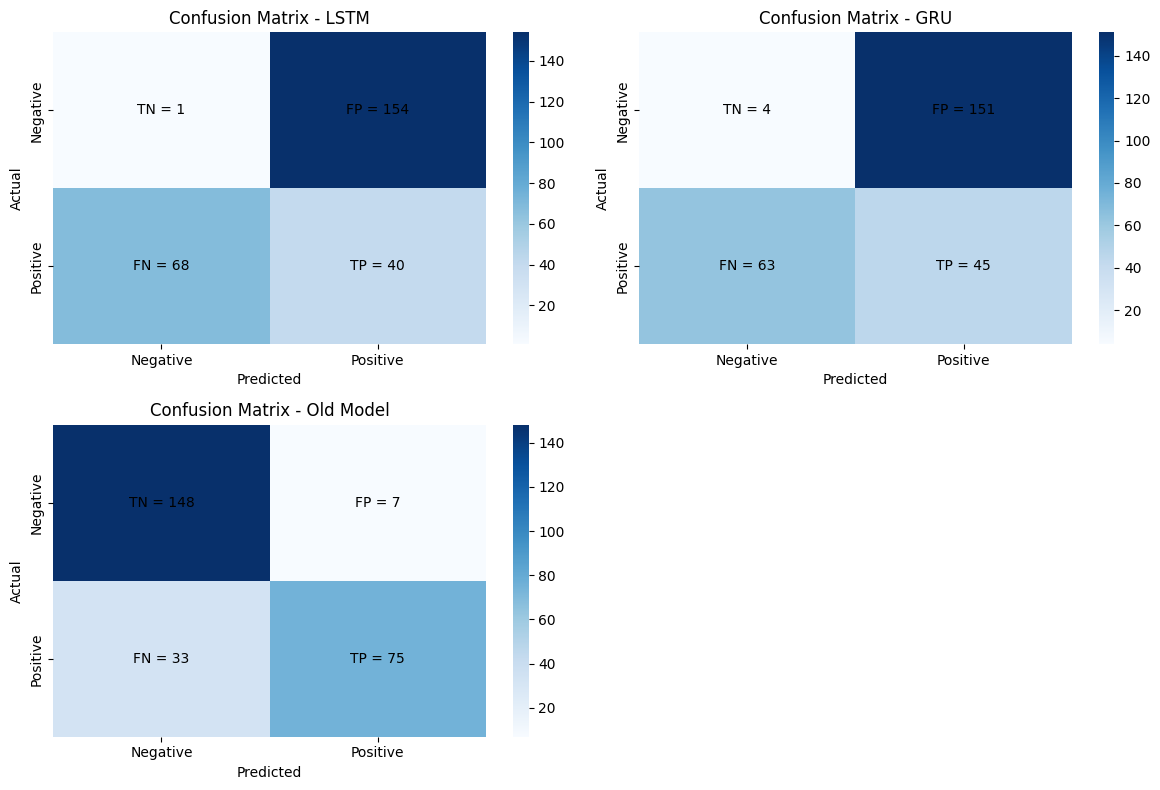

In [617]:
display_confusion_heatmap(y_test, y_preds, model_names)

### `Test Accuracy`

In [618]:
for i, y_pred in enumerate(y_preds):
    acc = check_test_accuracy(y_pred, y_test)
    print(f"Model: {model_names[i]} - Test accuracy: {acc}")

Model: LSTM - Test accuracy: 0.155893536121673
Model: GRU - Test accuracy: 0.18631178707224336
Model: Old Model - Test accuracy: 0.8479087452471483


### `Save Model`

In [619]:
# # EXPORT
# KERAS_MODEL = "model.h5"
# WORD2VEC_MODEL = "model.w2v"
# TOKENIZER_MODEL = "tokenizer.pkl"
# ENCODER_MODEL = "encoder.pkl"

In [620]:
# import pickle

In [621]:
# model.save(KERAS_MODEL)
# w2v_model.save(WORD2VEC_MODEL)
# pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)